In [3]:
import torch
import dgl
print(dgl.__version__)

0.9.1


In [4]:
# 载入OGB的Graph Property Prediction数据集
import dgl
import torch
from ogb.graphproppred import DglGraphPropPredDataset

def _collate_fn(batch):
    # 小批次是一个元组(graph, label)列表
    graphs = [e[0] for e in batch]
    g = dgl.batch(graphs)
    labels = [e[1] for e in batch]
    labels = torch.stack(labels, 0)
    return g, labels

# 载入数据集
dataset = DglGraphPropPredDataset(name='ogbg-molhiv')
split_idx = dataset.get_idx_split()

print(dataset)

DglGraphPropPredDataset(41127)


In [5]:
len(dataset)

41127

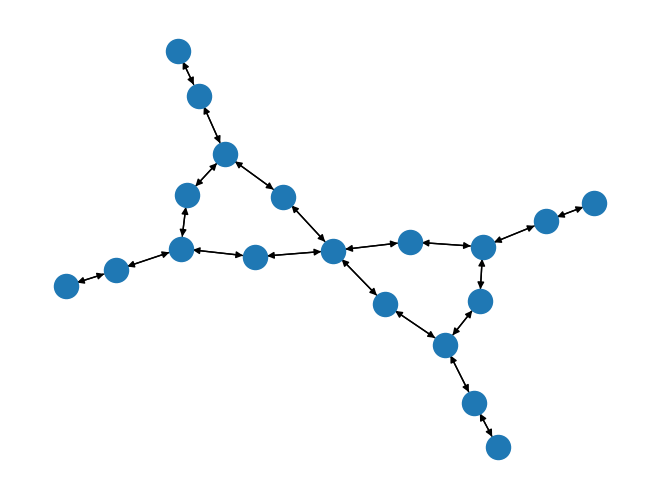

In [6]:
import networkx as nx
nx.draw(dataset[0][0].to_networkx())

In [7]:
# 载入OGB的Node Property Prediction数据集
from ogb.nodeproppred import DglNodePropPredDataset

dataset = DglNodePropPredDataset(name='ogbn-proteins')
split_idx = dataset.get_idx_split()

# there is only one graph in Node Property Prediction datasets
# 在Node Property Prediction数据集里只有一个图
g, labels = dataset[0]
# 获取划分的标签
train_label = dataset.labels[split_idx['train']]
valid_label = dataset.labels[split_idx['valid']]
test_label = dataset.labels[split_idx['test']]

In [8]:
from ogb.linkproppred import DglLinkPropPredDataset

dataset = DglLinkPropPredDataset(name='ogbl-ppa')
split_edge = dataset.get_edge_split()

graph = dataset[0]
print(split_edge['train'].keys())
print(split_edge['valid'].keys())
print(split_edge['test'].keys())

dict_keys(['edge'])
dict_keys(['edge', 'edge_neg'])
dict_keys(['edge', 'edge_neg'])


In [9]:
import dgl

dataset = dgl.data.CiteseerGraphDataset()
graph = dataset[0]

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [10]:
import numpy as np
import torch

n_users = 1000
n_items = 500
n_follows = 3000
n_clicks = 5000
n_dislikes = 500
n_hetero_features = 10
n_user_classes = 5
n_max_clicks = 10

follow_src = np.random.randint(0, n_users, n_follows)
follow_dst = np.random.randint(0, n_users, n_follows)
click_src = np.random.randint(0, n_users, n_clicks)
click_dst = np.random.randint(0, n_items, n_clicks)
dislike_src = np.random.randint(0, n_users, n_dislikes)
dislike_dst = np.random.randint(0, n_items, n_dislikes)

hetero_graph = dgl.heterograph({
    ('user', 'follow', 'user'): (follow_src, follow_dst),
    ('user', 'followed-by', 'user'): (follow_dst, follow_src),
    ('user', 'click', 'item'): (click_src, click_dst),
    ('item', 'clicked-by', 'user'): (click_dst, click_src),
    ('user', 'dislike', 'item'): (dislike_src, dislike_dst),
    ('item', 'disliked-by', 'user'): (dislike_dst, dislike_src)})

hetero_graph.nodes['user'].data['feature'] = torch.randn(n_users, n_hetero_features)
hetero_graph.nodes['item'].data['feature'] = torch.randn(n_items, n_hetero_features)
hetero_graph.nodes['user'].data['label'] = torch.randint(0, n_user_classes, (n_users,))
hetero_graph.edges['click'].data['label'] = torch.randint(1, n_max_clicks, (n_clicks,)).float()
# 在user类型的节点和click类型的边上随机生成训练集的掩码
hetero_graph.nodes['user'].data['train_mask'] = torch.zeros(n_users, dtype=torch.bool).bernoulli(0.6)
hetero_graph.edges['click'].data['train_mask'] = torch.zeros(n_clicks, dtype=torch.bool).bernoulli(0.6)

In [11]:
# 构建一个2层的GNN模型
# 掩码作用 保证部分节点不参与训练
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        # 实例化SAGEConve，in_feats是输入特征的维度，out_feats是输出特征的维度，aggregator_type是聚合函数的类型
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # 输入是节点的特征
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [12]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [13]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [14]:
model = SAGE(in_feats=n_features, hid_feats=150, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

for epoch in range(70):
    model.train()
    # 使用所有节点(全图)进行前向传播计算
    logits = model(graph, node_features)
    # 计算损失值
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    # 计算验证集的准确度
    acc = evaluate(model, graph, node_features, node_labels, valid_mask)
    # 进行反向传播计算
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item(),acc)

    # 如果需要的话，保存训练好的模型。本例中省略

1.7929515838623047 0.15
1.775057077407837 0.238
1.7574958801269531 0.336
1.7393453121185303 0.394
1.7202529907226562 0.456
1.7000770568847656 0.498
1.6788291931152344 0.524
1.6566022634506226 0.558
1.6334205865859985 0.564
1.609316110610962 0.588
1.5843104124069214 0.594
1.5585405826568604 0.596
1.5321295261383057 0.6
1.5050851106643677 0.602
1.4774742126464844 0.614
1.4493743181228638 0.62
1.420820713043213 0.622
1.3919167518615723 0.618
1.3626927137374878 0.622
1.3332065343856812 0.626
1.30350923538208 0.626
1.273654818534851 0.628
1.243683934211731 0.63
1.213641881942749 0.634
1.1835582256317139 0.638
1.1534911394119263 0.64
1.1234709024429321 0.644
1.0935362577438354 0.646
1.0637221336364746 0.644
1.0340715646743774 0.644
1.0046254396438599 0.648
0.9754158854484558 0.648
0.9464825391769409 0.65
0.917855441570282 0.65
0.8895715475082397 0.656
0.8616609573364258 0.656
0.8341466784477234 0.656
0.8070590496063232 0.658
0.7804266214370728 0.662
0.7542720437049866 0.662
0.728627920150756

In [15]:
# Define a Heterograph Conv model

class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        # 实例化HeteroGraphConv，in_feats是输入特征的维度，out_feats是输出特征的维度，aggregate是聚合函数的类型
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # 输入是节点的特征字典
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [16]:
model = RGCN(n_hetero_features, 20, n_user_classes, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
labels = hetero_graph.nodes['user'].data['label']
train_mask = hetero_graph.nodes['user'].data['train_mask']

In [17]:
node_features = {'user': user_feats, 'item': item_feats}
h_dict = model(hetero_graph, {'user': user_feats, 'item': item_feats})
h_user = h_dict['user']
h_item = h_dict['item']
print(h_dict,h_user.shape,h_item.shape)

{'item': tensor([[ 0.9061,  1.0684, -0.5303, -0.5071,  1.8864],
        [-0.0382,  0.5174, -0.5846, -0.5079,  1.0569],
        [ 0.8836,  0.1197, -0.8555,  0.3376,  1.5510],
        ...,
        [-0.3610,  0.6729, -0.3531, -0.6160,  0.1664],
        [ 0.9617, -0.6918, -0.3297,  0.2260,  0.5065],
        [ 0.4144, -0.0102, -0.7638, -0.0995,  0.5587]], grad_fn=<SumBackward1>), 'user': tensor([[ 0.7106, -0.3577,  0.1665,  0.0808,  0.5631],
        [ 0.7504, -0.7203, -0.1126, -0.5626,  2.1501],
        [-0.2958, -0.0376,  0.0613,  0.8990,  0.7922],
        ...,
        [ 0.7778,  0.0869, -0.7383, -0.5242,  0.4208],
        [-0.1369, -0.3566, -0.3903,  0.3781,  1.3309],
        [ 0.2474, -0.4665, -0.3148,  0.3675,  0.8578]], grad_fn=<SumBackward1>)} torch.Size([1000, 5]) torch.Size([500, 5])


In [18]:
hetero_graph.num_nodes('item'),hetero_graph.num_nodes('user')

(500, 1000)

In [19]:
opt = torch.optim.Adam(model.parameters())

for epoch in range(10):
    model.train()
    # 使用所有节点的特征进行前向传播计算，并提取输出的user节点嵌入
    logits = model(hetero_graph, node_features)['user']
    # 计算损失值
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    # 计算验证集的准确度。在本例中省略。
    # 进行反向传播计算
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item(),acc)

    # 如果需要的话，保存训练好的模型。本例中省略。

1.9576088190078735 0.674
1.939908504486084 0.674
1.9230670928955078 0.674
1.9070775508880615 0.674
1.8919248580932617 0.674
1.8775508403778076 0.674
1.8639003038406372 0.674
1.8509597778320312 0.674
1.8387417793273926 0.674
1.8271989822387695 0.674


In [20]:
src = np.random.randint(0, 100, 500)
dst = np.random.randint(0, 100, 500)
# 同时建立反向边
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# 建立点和边特征，以及边的标签
edge_pred_graph.ndata['feature'] = torch.randn(100, 10)
edge_pred_graph.edata['feature'] = torch.randn(1000, 10)
edge_pred_graph.edata['label'] = torch.randn(1000)
# 进行训练、验证和测试集划分
edge_pred_graph.edata['train_mask'] = torch.zeros(1000, dtype=torch.bool).bernoulli(0.6)

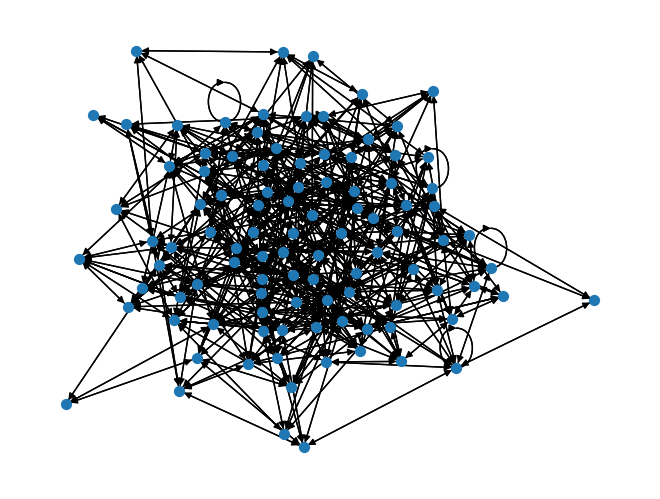

In [21]:
nx.draw(edge_pred_graph.to_networkx(),node_size=50)

In [22]:
edge_pred_graph.edata['train_mask'] = torch.zeros(1000, dtype=torch.bool).bernoulli(0.6)

In [23]:
import dgl.function as fn
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h是从5.1节的GNN模型中计算出的节点表示
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

In [24]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        # h是从5.1节的GNN模型中计算出的节点表示
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [25]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

In [26]:
node_features = edge_pred_graph.ndata['feature']
edge_label = edge_pred_graph.edata['label']
train_mask = edge_pred_graph.edata['train_mask']
model = Model(10, 20, 5)
opt = torch.optim.Adam(model.parameters())
for epoch in range(100):
    pred = model(edge_pred_graph, node_features)
    loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

94.98174285888672
88.971435546875
83.3622817993164
78.13594055175781
73.27360534667969
68.75390625
64.56483459472656
60.68606185913086
57.10261535644531
53.79550552368164
50.74448776245117
47.929813385009766
45.33329772949219
42.935813903808594
40.725948333740234
38.688323974609375
36.808475494384766
35.071617126464844
33.4658317565918
31.981430053710938
30.60660743713379
29.331451416015625
28.146697998046875
27.04435920715332
26.017704010009766
25.05938720703125
24.163921356201172
23.32596206665039
22.54125213623047
21.806217193603516
21.115379333496094
20.46518325805664
19.85255241394043
19.27445411682129
18.72799301147461
18.210878372192383
17.721010208129883
17.256227493286133
16.81489372253418
16.39505958557129
15.995560646057129
15.615097999572754
15.252384185791016
14.906250953674316
14.575603485107422
14.259479522705078
13.958494186401367
13.670171737670898
13.393839836120605
13.1290864944458
12.874871253967285
12.630558967590332
12.395573616027832
12.168889045715332
11.9505376

In [27]:
class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        # h是从5.1节中对每种类型的边所计算的节点表示
        with graph.local_scope():
            graph.ndata['h'] = h   #一次性为所有节点类型的 'h'赋值
            # 指定某种特殊的边
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

In [28]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h, etype):
        # h是从5.1节中对异构图的每种类型的边所计算的节点表示
        with graph.local_scope():
            graph.ndata['h'] = h   #一次性为所有节点类型的 'h'赋值
            graph.apply_edges(self.apply_edges, etype=etype)
            return graph.edges[etype].data['score']

In [29]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, x, etype):
        h = self.sage(g, x)
        return self.pred(g, h, etype)

In [30]:
model = Model(10, 20, 5, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
label = hetero_graph.edges['click'].data['label']
train_mask = hetero_graph.edges['click'].data['train_mask']
node_features = {'user': user_feats, 'item': item_feats}

In [31]:
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    pred = model(hetero_graph, node_features, 'click')
    loss = ((pred[train_mask] - label[train_mask]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

41.84418487548828
40.31624984741211
38.905513763427734
37.601043701171875
36.38758087158203
35.250572204589844
34.17774963378906
33.15914535522461
32.185245513916016
31.248844146728516
30.34299659729004
29.46220588684082
28.60175132751465
27.7579345703125
26.928068161010742
26.110151290893555
25.302845001220703
24.504756927490234
23.71630859375
22.938148498535156
22.171924591064453
21.420326232910156
20.686553955078125
19.974376678466797
19.28759765625
18.63096809387207
18.009849548339844
17.42926025390625
16.894521713256836
16.41007423400879
15.979060173034668
15.603784561157227
15.284601211547852
15.01986312866211
14.806193351745605
14.637812614440918
14.507132530212402
14.404996871948242
14.321542739868164
14.247076988220215
14.172840118408203
14.091954231262207
13.999500274658203
13.89273738861084
13.77122688293457
13.63642406463623
13.490954399108887
13.338500022888184
13.183009147644043
13.028173446655273
12.877542495727539
12.733470916748047
12.597796440124512
12.471505165100098

In [32]:
dec_graph = hetero_graph['user', :, 'item']
dec_graph

Graph(num_nodes={'user': 1000, 'item': 500},
      num_edges={('user', 'click+dislike', 'item'): 5500},
      metagraph=[('user', 'item', 'click+dislike')])

In [33]:
edge_label = dec_graph.edata[dgl.ETYPE]
edge_label

tensor([2, 2, 2,  ..., 3, 3, 3])

In [34]:
class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_dims, n_classes):
        super().__init__()
        self.W = nn.Linear(in_dims * 2, n_classes)

    def apply_edges(self, edges):
        x = torch.cat([edges.src['h'], edges.dst['h']], 1)
        y = self.W(x)
        return {'score': y}

    def forward(self, graph, h):
        # h是从5.1节中对异构图的每种类型的边所计算的节点表示
        with graph.local_scope():
            graph.ndata['h'] = h   #一次性为所有节点类型的 'h'赋值
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [35]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroMLPPredictor(out_features, len(rel_names))
    def forward(self, g, x, dec_graph):
        h = self.sage(g, x)
        return self.pred(dec_graph, h)

In [37]:
model = Model(10, 20, 5, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
node_features = {'user': user_feats, 'item': item_feats}

opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    logits = model(hetero_graph, node_features, dec_graph)
    loss = F.cross_entropy(logits, edge_label)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

1.7952098846435547
1.7530566453933716
1.7114936113357544
1.6705033779144287
1.6300550699234009
1.5901154279708862
1.550695538520813
1.5117971897125244
1.4734054803848267
1.435516119003296


In [38]:
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h是从5.1节的GNN模型中计算出的节点表示
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

In [39]:
def construct_negative_graph(graph, k):
    src, dst = graph.edges()

    neg_src = src.repeat_interleave(k)
    neg_dst = torch.randint(0, graph.num_nodes(), (len(src) * k,))
    return dgl.graph((neg_src, neg_dst), num_nodes=graph.num_nodes())

In [40]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, neg_g, x):
        h = self.sage(g, x)
        return self.pred(g, h), self.pred(neg_g, h)

In [42]:
def compute_loss(pos_score, neg_score):
    # 间隔损失
    n_edges = pos_score.shape[0]
    return (1 - pos_score.unsqueeze(1) + neg_score.view(n_edges, -1)).clamp(min=0).mean()

node_features = graph.ndata['feat']
n_features = node_features.shape[1]
k = 5
model = Model(n_features, 100, 100)
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    negative_graph = construct_negative_graph(graph, k)
    pos_score, neg_score = model(graph, negative_graph, node_features)
    loss = compute_loss(pos_score, neg_score)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

0.9991170763969421
0.9978369474411011
0.995951235294342
0.9933043122291565
0.9897497296333313
0.9850509762763977
0.9790405035018921
0.9714757204055786
0.962224543094635
0.9508519172668457


In [43]:
node_embeddings = model.sage(graph, node_features)
node_embeddings

tensor([[ 0.0159, -0.0268, -0.0082,  ..., -0.0287, -0.0135, -0.0109],
        [ 0.0074,  0.0104, -0.0331,  ..., -0.0197, -0.0295, -0.0206],
        [ 0.0097,  0.0230,  0.0397,  ..., -0.0100, -0.0172,  0.0129],
        ...,
        [ 0.0172,  0.0005,  0.0313,  ..., -0.0321,  0.0307,  0.0067],
        [-0.0166,  0.0206,  0.0191,  ..., -0.0020, -0.0087, -0.0132],
        [ 0.0023,  0.0389,  0.0604,  ...,  0.0123,  0.0072, -0.0018]],
       grad_fn=<AddBackward0>)

In [44]:
class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        # h是从5.1节中对异构图的每种类型的边所计算的节点表示
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

In [45]:
def construct_negative_graph(graph, k, etype):
    utype, _, vtype = etype
    src, dst = graph.edges(etype=etype)
    neg_src = src.repeat_interleave(k)
    neg_dst = torch.randint(0, graph.num_nodes(vtype), (len(src) * k,))
    return dgl.heterograph(
        {etype: (neg_src, neg_dst)},
        num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

In [46]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, neg_g, x, etype):
        h = self.sage(g, x)
        return self.pred(g, h, etype), self.pred(neg_g, h, etype)

In [48]:
def compute_loss(pos_score, neg_score):
    # 间隔损失
    n_edges = pos_score.shape[0]
    return (1 - pos_score.unsqueeze(1) + neg_score.view(n_edges, -1)).clamp(min=0).mean()

k = 5
model = Model(10, 20, 5, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
node_features = {'user': user_feats, 'item': item_feats}
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    negative_graph = construct_negative_graph(hetero_graph, k, ('user', 'click', 'item'))
    pos_score, neg_score = model(hetero_graph, negative_graph, node_features, ('user', 'click', 'item'))
    loss = compute_loss(pos_score, neg_score)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

1.4875493049621582
1.463617205619812
1.4341107606887817
1.4050408601760864
1.3760002851486206
1.3487528562545776
1.3276079893112183
1.3054808378219604
1.293243646621704
1.2670834064483643


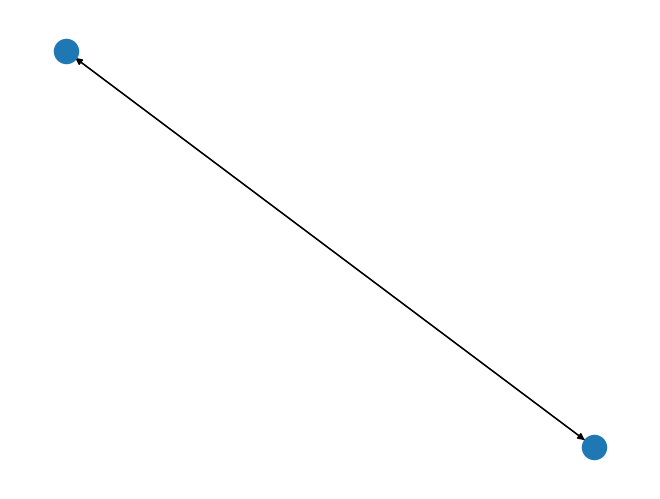

In [49]:
import dgl
import torch

g1 = dgl.graph(([0, 1], [1, 0]))
g1.ndata['h'] = torch.tensor([1., 2.])
g2 = dgl.graph(([0, 1], [1, 2]))
g2.ndata['h'] = torch.tensor([1., 2., 3.])
nx.draw(g1.to_networkx())

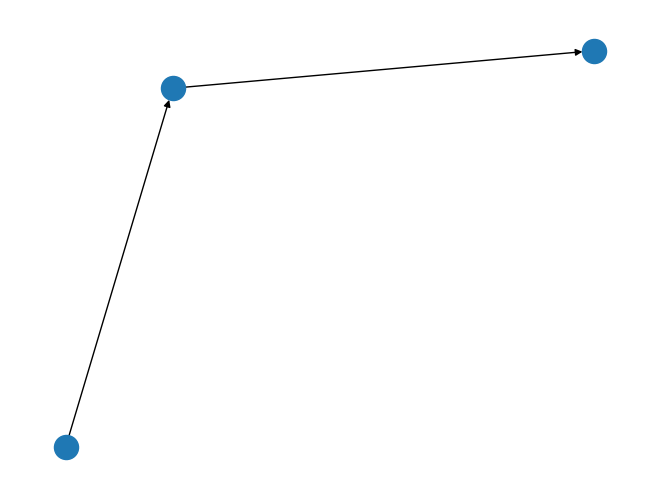

In [50]:
nx.draw(g2.to_networkx())

In [51]:
dgl.readout_nodes(g1, 'h')
# tensor([3.])  # 1 + 2

tensor([3.])

In [52]:
bg = dgl.batch([g1, g2])
dgl.readout_nodes(bg, 'h')

tensor([3., 6.])

In [53]:
bg.ndata['h']

tensor([1., 2., 1., 2., 3.])

In [54]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # 应用图卷积和激活函数
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        with g.local_scope():
            g.ndata['h'] = h
            # 使用平均读出计算图表示
            hg = dgl.mean_nodes(g, 'h')
            return self.classify(hg)

In [56]:
import dgl.data
dataset = dgl.data.GINDataset('MUTAG',False)

In [57]:
from dgl.dataloading import GraphDataLoader
dataloader = GraphDataLoader(
    dataset,
    batch_size=1024,
    drop_last=False,
    shuffle=True)

In [60]:
import torch.nn.functional as F

# 这仅是个例子，特征尺寸是7
model = Classifier(7, 20, 5)
opt = torch.optim.Adam(model.parameters())
for epoch in range(100):
    for batched_graph, labels in dataloader:
        feats = batched_graph.ndata['attr']
        logits = model(batched_graph, feats)
        loss = F.cross_entropy(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        print(loss.item())

1.5116294622421265
1.5070745944976807
1.5024962425231934
1.4978793859481812
1.4932187795639038
1.488540768623352
1.4838229417800903
1.4791136980056763
1.4744459390640259
1.4697338342666626
1.4650102853775024
1.460247278213501
1.455430269241333
1.4505255222320557
1.4455485343933105
1.4404959678649902
1.4353867769241333
1.430213451385498
1.4249662160873413
1.4196504354476929
1.4142518043518066
1.4087494611740112
1.4031559228897095
1.3974679708480835
1.3916330337524414
1.3856945037841797
1.3796628713607788
1.3735374212265015
1.367281436920166
1.360824704170227
1.3542195558547974
1.347415804862976
1.3405053615570068
1.333457350730896
1.3262524604797363
1.3188576698303223
1.3113114833831787
1.3036123514175415
1.2957243919372559
1.287628412246704
1.2792991399765015
1.2706722021102905
1.261818289756775
1.2527803182601929
1.243577241897583
1.2342164516448975
1.2246919870376587
1.2149622440338135
1.2050477266311646
1.194969654083252
1.184773325920105
1.1744499206542969
1.1640170812606812
1.1535

In [62]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs是节点的特征
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [63]:
class HeteroClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes, rel_names):
        super().__init__()

        self.rgcn = RGCN(in_dim, hidden_dim, hidden_dim, rel_names)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        h = g.ndata['feat']
        h = self.rgcn(g, h)
        with g.local_scope():
            g.ndata['h'] = h
            # 通过平均读出值来计算单图的表征
            hg = 0
            for ntype in g.ntypes:
                hg = hg + dgl.mean_nodes(g, 'h', ntype=ntype)
            return self.classify(hg)

In [64]:
# etypes是一个列表，元素是字符串类型的边类型
model = HeteroClassifier(10, 20, 5, etypes)
opt = torch.optim.Adam(model.parameters())
for epoch in range(20):
    for batched_graph, labels in dataloader:
        logits = model(batched_graph)
        loss = F.cross_entropy(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()

NameError: name 'etypes' is not defined

In [ ]:
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)
dataloader = dgl.dataloading.NodeDataLoader(
    g, train_nids, sampler,
    batch_size=1024,
    shuffle=True,
    drop_last=False,
    num_workers=4)

In [68]:
class StochasticTwoLayerGCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.conv1 = dgl.nn.GraphConv(in_features, hidden_features)
        self.conv2 = dgl.nn.GraphConv(hidden_features, out_features)

    def forward(self, blocks, x):
        x = F.relu(self.conv1(blocks[0], x))
        x = F.relu(self.conv2(blocks[1], x))
        return x

In [69]:
class TwoLayerGCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_features, hidden_features)
        self.conv2 = dglnn.GraphConv(hidden_features, out_features)

    def forward(self, g, x):
        x = F.relu(self.conv1(g, x))
        x = F.relu(self.conv2(g, x))
        return x

In [3]:
from ogb.linkproppred import DglLinkPropPredDataset
dataset=DglLinkPropPredDataset('ogbl-ddi')

RuntimeError: Stopped downloading due to interruption.

In [75]:
splitdataset=dataset.get_edge_split()

In [77]:
splitdataset['train'],splitdataset['valid'],splitdataset['test']

({'edge': tensor([[4039, 2424],
          [4039,  225],
          [4039, 3901],
          ...,
          [ 647,  708],
          [ 708,  338],
          [ 835, 3554]])},
 {'edge': tensor([[ 722,  548],
          [ 874, 3436],
          [ 838, 1587],
          ...,
          [3661, 3125],
          [3272, 3330],
          [1330,  776]]),
  'edge_neg': tensor([[   0,   58],
          [   0,   84],
          [   0,   90],
          ...,
          [4162, 4180],
          [4168, 4260],
          [4180, 4221]])},
 {'edge': tensor([[2198, 1172],
          [1205,  719],
          [1818, 2866],
          ...,
          [ 326, 1109],
          [ 911, 1250],
          [4127, 2480]]),
  'edge_neg': tensor([[   0,    2],
          [   0,   16],
          [   0,   42],
          ...,
          [4168, 4259],
          [4208, 4245],
          [4245, 4259]])})

In [1]:
import dgl
dgl.contrib.sampling.random_walk(dataset)

Using backend: pytorch


NameError: name 'dataset' is not defined